## Parte 3 

### Análisis de componentes no analizados

#### Generacion de archivos con datos no procesados

Se extraen los textos que no han sido procesados:

In [3]:
import pandas as pd
import numpy as np
dfNegativeNo = pd.read_json('dfNegative.json')
dfNegativeNo = dfNegativeNo.dropna()
dfNegativeNo = dfNegativeNo[~dfNegativeNo['tree'].str.contains("Root").fillna(False)]
dfNegativeNo['tree'] =  np.nan
dfNegativeNo.to_json(r'dfNegativeNo.json')

In [4]:
dfPositiveNo = pd.read_json('dfPositive.json')
dfPositiveNo = dfPositiveNo.dropna()
dfPositiveNo = dfPositiveNo[~dfPositiveNo['tree'].str.contains("Root").fillna(False)]
dfPositiveNo['tree'] =  np.nan
dfPositiveNo.to_json(r'dfPositiveNo.json')

#### Análisis de componentes

Se hacen los analisis de los componentes que no se procesaron (alrededor de un 50% de los casos):

In [17]:
import os
import docker
import math
import signal
import multiprocessing
import time
import pickle5 as pickle
import numpy as np

client = docker.from_env()
from IPython.display import clear_output


class TimeoutException(Exception): 
    pass

def timeout_handler(signum, frame): 
    raise TimeoutException

signal.signal(signal.SIGALRM, timeout_handler)

def coherence(row):

    if((pd.isna(row["tree"]))):
        os.system("echo '"+row['text']+"' > input.txt")
        os.system("cp input.txt /Users/raulbarrantes/tmp/")
        clear_output(wait=True)
        print(row.name)
        signal.alarm(360)
        try:
            return client.containers.run("nlpbox/codra", "/tmp/input.txt",  tty=True, volumes={'/Users/raulbarrantes/tmp': {'bind': '/tmp/'}},)
        except TimeoutException: 
            return "Timeout"
        except:
            return "Error del formato de archivo"
    else:
        return row["tree"]
    


In [ ]:
for n in range(0, 5000, 50):
    dfNegativeNo['tree'] = dfNegativeNo.iloc[0:n+1].apply(coherence,axis=1)
    dfNegativeNo.to_json(r'dfNegativeNo.json')

In [ ]:
for n in range(0, 5000, 50):
    dfPositiveNo['tree'] = dfPositiveNo.iloc[0:n+1].apply(coherence,axis=1)
    dfPositiveNo.to_json(r'dfPositiveNo.json')

In [5]:
dfNegativeNo = pd.read_json('dfNegativeNo.json')

In [6]:
dfPositiveNo = pd.read_json('dfPositiveNo.json')

### Análisis de patrones en los textos

In [35]:
import pandas as pd
dfNegative = pd.read_json('dfNegative.json')
dfPositive = pd.read_json('dfPositive.json')
dfPositive = dfPositive.dropna()
dfPositive = dfPositive[dfPositive['tree']!='No']
dfPositive = dfPositive[dfPositive['tree'].str.contains("Root").fillna(False)]
dfNegative = dfNegative.dropna()
dfNegative = dfNegative[dfNegative['tree']!='No']
dfNegative = dfNegative[dfNegative['tree'].str.contains("Root").fillna(False)]

In [36]:
dfNegative = dfNegative.reset_index(drop=True)
dfPositive = dfPositive.reset_index(drop=True)

Se guardan los textos en una archivo json.

In [45]:
dfNegative.to_json(r'dfNegativeSi.json')
dfPositive.to_json(r'dfPositiveSi.json')

### Extracción de estructura de los textos

Se extraen los textos mediante regex:

In [222]:
a = re.sub(r"\( (Nucleus).*\) \)", "(\1)", dfPositive['tree'].iloc[18000])
b = re.sub(r"\( (Satellite).*\) \)", "(Satellite)",a)
c = re.sub(r"\( (Nucleus) .*\)", "(Nucleus", b)
d = re.sub(r"\( (Satellite) .*\)", "(Satellite",c)
e = re.sub(r"\( (Satellite) .*\)", "(Satellite",d)
f = re.sub(r"\( Root .*\n", "",e)
g = re.sub(r"\n", "",f)
h = re.sub(r" ", "",g)
i = re.sub(r"\r", "",h)
j = re.sub(r"\)$", "",i)
j

'(Nucleus(\x01)(Satellite(Nucleus(\x01)(Satellite))(Nucleus(\x01)(\x01))))(Satellite)'

In [203]:
import re
def get_structure(sentence):
    a = re.sub(r"\( (Nucleus).*\) \)", "(/1)", sentence)
    b = re.sub(r"\( (Satellite).*\) \)", "(Satellite)",a)
    c = re.sub(r"\( (Nucleus) .*\)", "(Nucleus", b)
    d = re.sub(r"\( (Satellite) .*\)", "(Satellite",c)
    e = re.sub(r"\( (Satellite) .*\)", "(Satellite",d)
    f = re.sub(r"\( Root .*\n", "",e)
    g = re.sub(r"\n", "",f)
    h = re.sub(r" ", "",g)
    i = re.sub(r"\r", "",h)
    j = re.sub(r"\)$", "",i)
    return j

In [204]:
dfPositive['structure'] = dfPositive['tree'].apply(lambda x: get_structure(x))
dfNegative['structure'] = dfNegative['tree'].apply(lambda x: get_structure(x))

Aquí se muestran las estructuras más comunes del corpus positivo:

In [285]:
dfPositive['structure'].value_counts()[:10]

(Nucleus)(Satellite)                        1798
(Satellite)(Nucleus)                         805
(Nucleus)(Satellite(Nucleus)(Satellite))     519
(Nucleus)(Nucleus)                           437
(Nucleus(Nucleus)(Satellite))(Satellite)     430
(Nucleus)(Satellite(Satellite)(Nucleus))     259
(Satellite)(Nucleus(Nucleus)(Satellite))     257
(Nucleus(Nucleus)(Satellite))(Nucleus)       245
(Nucleus)(Nucleus(Nucleus)(Satellite))       235
(Nucleus)(Satellite(Nucleus)(Nucleus))       206
Name: structure, dtype: int64

Aquí se muestran las estructuras más comunes del corpus negativo:

In [286]:
dfNegative['structure'].value_counts()[:10]

(Nucleus)(Satellite)                        5069
(Satellite)(Nucleus)                        1440
(Nucleus)(Satellite(Nucleus)(Satellite))    1116
(Nucleus)(Nucleus)                           710
(Nucleus(Nucleus)(Satellite))(Satellite)     633
(Nucleus(Nucleus)(Satellite))(Nucleus)       590
(Nucleus)(Satellite(Satellite)(Nucleus))     424
(Satellite)(Nucleus(Nucleus)(Satellite))     405
(Nucleus)(Nucleus(Nucleus)(Satellite))       370
(Nucleus(Satellite)(Nucleus))(Satellite)     314
Name: structure, dtype: int64

### Cálculo de la profundidad de los textos

Se calcula la profundidad de las oraciones y sentencias.

In [281]:
def deepness(str_):
    count = 0
    a = 0
    for c in str_:
        if (c == ')'):
            count += 1
        else:
            if (count > a):
                a = count
            count = 0
    if (count > a):
        a = count
    return a

In [282]:
dfPositive['deepness'] = dfPositive['structure'].apply(lambda x: deepness(x))
dfNegative['deepness'] = dfNegative['structure'].apply(lambda x: deepness(x))

<BarContainer object of 5 artists>

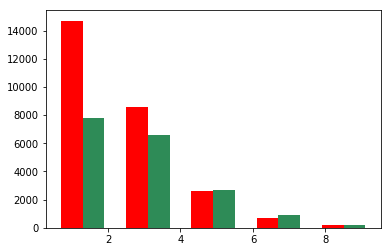

In [292]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(dfNegative['deepness'], bins=5, range=(1,10))
b_heights, b_bins = np.histogram(dfPositive['deepness'], bins=5, range=(1,10))

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='red')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

### Medias

In [293]:
dfPositive["deepness"].mean()

3.1986943880629766

In [295]:
dfNegative["deepness"].mean()

2.693697055640557

### Medianas

In [296]:
dfPositive["deepness"].median()

3.0

In [297]:
dfNegative["deepness"].median()

2.0